SEE WORD

From Masked data?

In [2]:
from_masked = False

Imports

In [3]:
import My_functions as Mf
import os
import numpy as np
import scipy
from scipy.constants import g, pi
import matplotlib.pyplot as plt

load data

In [4]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output', 'Multy')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot')

multy_cut_image = 'multy_cut_image'
if from_masked:
    multy_cut_image = multy_cut_image+ '_masked'
multy_cut_image_folder = os.path.join(save_folder, multy_cut_image)


name_of_file_PTV = 'data_from_PTV.pkl'
name_of_file_PIV = 'data_from_PIV.pkl'
if from_masked:
    name_of_file_PIV = name_of_file_PIV[:-4] + '_Mask.pkl'


sphere_location_absolute, PIV_origin_location, Selected_area_for_PIV, scaling_factor, object_range, sphere_diameter, sphere_location_relative, origin = Mf.load_pickle(os.path.join(save_folder, name_of_file_PIV))
sphere_location_meter_PTV, velocitys_meter_PTV = Mf.load_pickle(os.path.join(save_folder, name_of_file_PTV))

sphere attributes

In [5]:
rho_sphere = 1134 # [kg/m^3]
sphere_volume = 4/3*pi*(sphere_diameter/2)**3
sphere_mass = rho_sphere*sphere_volume
mg = sphere_mass*g
print(f'mg = {mg} [N]')

mg = 0.005031845588225888 [N]


Set parameters

In [6]:
upper_density = 1130 #[kg/m^3]
lower_density = 1120 #[kg/m^3]

inteface_upper = 0.25
inteface_lower = 0.22

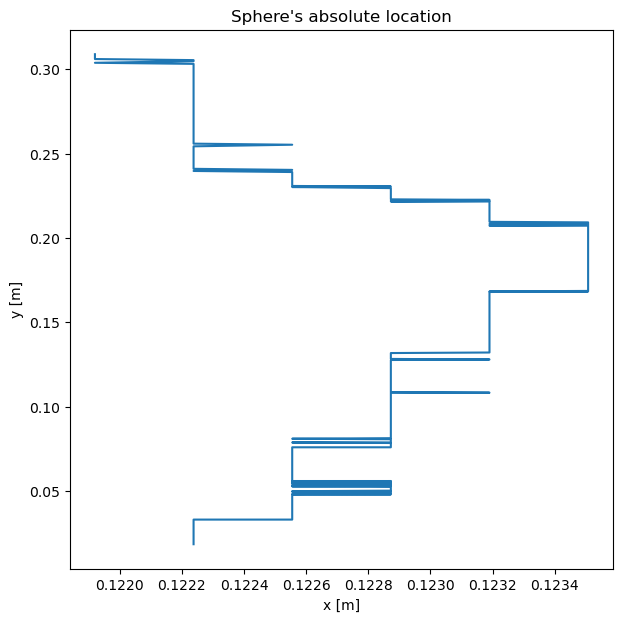

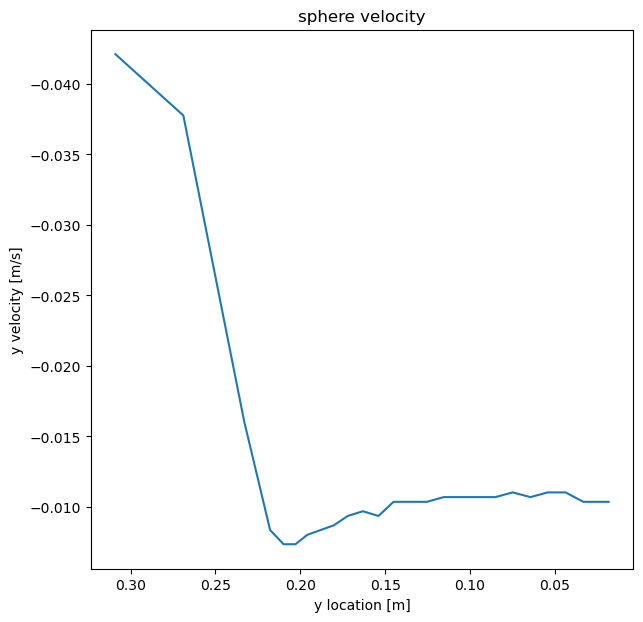

In [7]:
sphere_location_meter_PTV = np.array(sphere_location_meter_PTV)
velocitys_meter_PTV = np.array(velocitys_meter_PTV)
x_axis = sphere_location_meter_PTV[:, 0]
y_axis = sphere_location_meter_PTV[:, 1]
y_velocity = velocitys_meter_PTV[:, 1]

#plot absolute location
fig, ax = plt.subplots(figsize=(7,7))
plt.title("Sphere's absolute location")
plt.plot(x_axis, y_axis)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()


#plot vleocity (y axis only)
fig, ax = plt.subplots(figsize=(7,7))
plt.title("sphere velocity")
plt.plot(y_axis, y_velocity)
ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

Creating a callable function of y location vs y velocity

לא יעבוד כאשר יש כדור קופץ כי הפונקציה היא לא חד חד ערכית

In [8]:
y_velocity_meter_func = Mf.creat_callable_function_of_data(y_axis, y_velocity)

$\color{red}$ Now we will set the sphere location with respect to PIV rectangle origin bottom left corner

In [9]:
#make "sphere location" origin (0,0) same as PIV origin (0,0)
sphere_location_relativ_to_piv=[]
for ind,el in enumerate(sphere_location_absolute):
    sphere_location_relativ_to_piv.append([el[0]-PIV_origin_location[ind][0], el[1]-PIV_origin_location[ind][1]])

# in pixel
sphere_location_pixel = np.array(sphere_location_relativ_to_piv)*scaling_factor

The density function

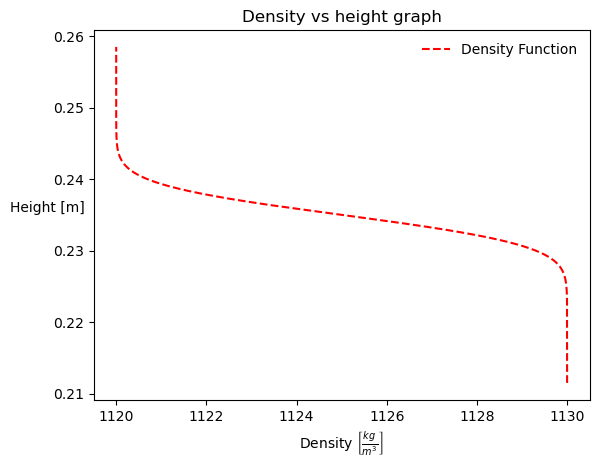

In [19]:
import My_functions as Mf
amplitude = (upper_density-lower_density)/2
middle_of_density = np.mean([upper_density, lower_density])
inteface_center = np.mean([inteface_upper, inteface_lower]) #[m]
interface_width = inteface_upper-inteface_lower #[m]


rho_function = Mf.density_function(amplitude = amplitude, interface_width = interface_width, center_of_interface = inteface_center, mean_density_value = middle_of_density, plot = False)

if True:
    x_values = np.linspace(inteface_center-inteface_center*0.1, inteface_center+0.1*inteface_center, 1000)
    y_values = rho_function(x_values)
    plt.title('Density vs height graph')
    plt.plot(y_values, x_values, '--', label='Density Function', color='red')
    plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
    ylabel = plt.ylabel('Height [m]', rotation=0)
    ylabel.set_verticalalignment('bottom')  # Align at the bottom of the label
    ylabel.set_y(ylabel.get_position()[1] - 0)
    plt.legend(fancybox=True, framealpha=0)
    plt.show()

In [11]:
F_y = []
F_y_and_loc = []
b = 2*sphere_diameter

txt_files_path = Mf.files_in_folder(save_folder, 'txt', full_path = True)
txt_files_path_1 = []


for el in txt_files_path:
    if from_masked:
        if "masked" in el:
            txt_files_path_1.append(el)
    else:
        if not "masked" in el:
            txt_files_path_1.append(el)

txt_files_path = txt_files_path_1
txt_files_path_1 = 0

Plot the spheres?

In [12]:
if False:
    Mf.display_images_with_points_napari(multy_cut_image_folder,  sphere_location_relative)
#the line below works only in py files:
# Mf.click_and_get_y(density_at_y, y_location)

The force acting on the water

<img title="Control Volume Integral" alt="Alt text" src="../Picture/IMG for markdown/control_vol_int.png">

we need to find the relevant place in Y for sum1 and sum2, and to cut the list for -2a<x<2a

In [13]:
# if show:
#     pictures_list = Mf.find_pictures(multy_cut_image_folder)
#     print("the red dot is the sphere's location With respect to the bottom left corner")

print(len(sphere_location_relativ_to_piv))
for ind, el in enumerate(sphere_location_relativ_to_piv):
    upper_location_rel = sphere_location_relativ_to_piv[ind][1] + b
    lower_location_rel = sphere_location_relativ_to_piv[ind][1] - b

    upper_location_absolute = sphere_location_absolute[ind][1] + b
    lower_location_absolute = sphere_location_absolute[ind][1] - b

    x, y, u, v = Mf.txt_to_column(txt_files_path[ind])

    start_y_upper, end_y_upper = Mf.find_closest_range_to_values_in_array(y, upper_location_rel) #return indexs
    start_y_lower, end_y_lower = Mf.find_closest_range_to_values_in_array(y, lower_location_rel) #return indexs

    start_x = Mf.find_closest_values_in_array(x, sphere_location_relativ_to_piv[ind][0] - 2*sphere_diameter)
    end_x = Mf.find_closest_values_in_array(x, sphere_location_relativ_to_piv[ind][0] + 2*sphere_diameter)

    v_upper = v[start_y_upper: end_y_upper][start_x: end_x] # [m/s]
    v_lower = v[start_y_lower: end_y_lower][start_x: end_x] # [m/s]

    x_values = x[start_x: end_x] # [m]

    #note: sphere_velocity[ind][1] is the control volume velocity V_c
    w_squared_upper = (np.array(v_upper) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    w_squared_lower = (np.array(v_lower) - y_velocity_meter_func(sphere_location_absolute[ind][1]))**2 # [m^2 / s^2]
    
    sum_upper = scipy.integrate.trapz(w_squared_upper, x_values) # [m^3 / s^2]
    sum_lower = scipy.integrate.trapz(w_squared_lower, x_values) # [m^3 / s^2]


    # the force acting on the WATER:
    F_y_el = 4*sphere_diameter*(rho_function(upper_location_absolute)*sum_upper - rho_function(lower_location_absolute)*sum_lower) # [N]

##################
    # לקחת בחשבון הפרש לחצים בגלל הפרש גבהים במים?

    # צריך להפוך את הציר של מיקום הכדור ולעשות את שפת המים כ 0 כדי לקבל את הגובה
    #top of the tank is located at 0.6
    # #take in account the force due to pressure
    # top_of_tank = 0.6 #[m]
    # F_y_el  = F_y_el + 4*sphere_diameter**2*(((top_of_tank - sphere_location_absolute[ind][1]) + b)*rho_2*g - ((top_of_tank - sphere_location_absolute[ind][1])  - b)*rho_1*g)

##################

    # appending the force acting on the SPHERE not on the water:
    F_y.append(-F_y_el)
    F_y_and_loc.append([sphere_location_absolute[ind][1], -F_y_el])
    
    # if show:
    #     fig, ax = plt.subplots(figsize=(7,7))
    #     img = Mf.read_image(pictures_list[ind])
    #     imgy = np.copy(img)[::-1]
    #     # img.shape[0] => Y dimentions and img.shape[1] => X dimentions
    #     plt.imshow(imgy, cmap='gray', origin='lower', extent = (0, img.shape[1]/scaling_factor, 0, img.shape[0]/scaling_factor)) # make sure the origin is left bottom corner
    #     plt.scatter(sphere_location_relativ_to_piv[ind][0], sphere_location_relativ_to_piv[ind][1], s = 100, c = 'red')
    #     plt.title(os.path.basename(pictures_list[ind]))
    #     ax.set_xlabel('x [m]')
    #     ax.set_ylabel('y [m]')
    #     plt.show()

266


Force from control volume is the dynamic force.

the bouyance force in present even if the flow field is zero and the water is stationary

In [14]:
save_file_name = 'Force_from_control_volume.pkl'
if from_masked:
    save_file_name = save_file_name[:-4] + '_Mask.pkl'

file_path = os.path.join(save_folder, save_file_name)

Mf.save_pickle(file_path, F_y)


buoyancy = rho_function(0.6)*sphere_volume*g

print('\nmg : ', -mg, '\nbuoyancy : ', buoyancy)


mg :  -0.005031845588225888 
buoyancy :  0.004969724037753963


guessing_interface location

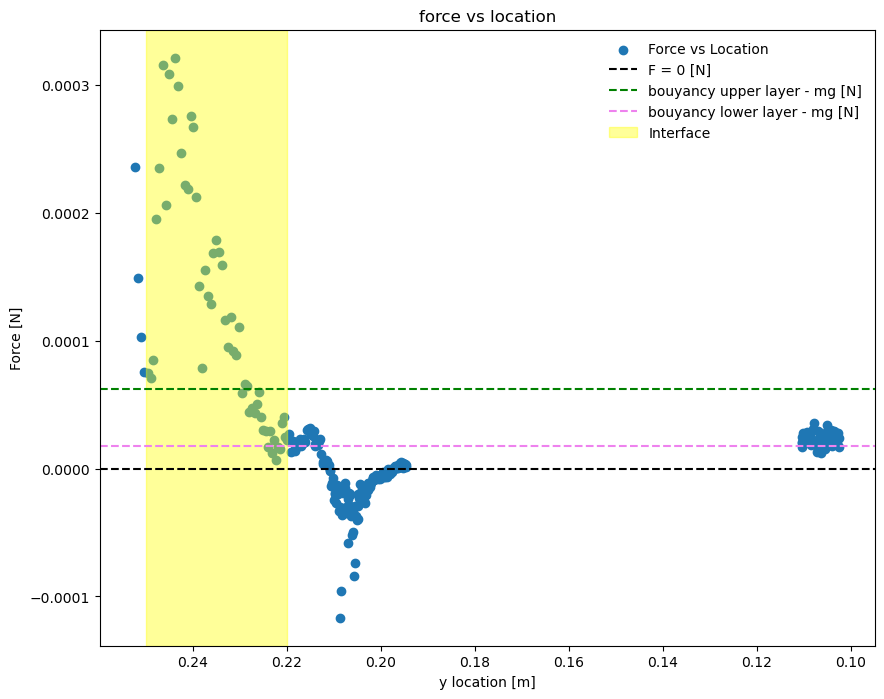

In [15]:
F_y_and_loc_np = np.array(F_y_and_loc)
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('force vs location')
ax.scatter(F_y_and_loc_np[:,0], F_y_and_loc_np[:,1], label='Force vs Location')

ax.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='bouyancy upper layer - mg [N]')
ax.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='bouyancy lower layer - mg [N]')


# Define the coordinates and dimensions of the rectangle
rect_x = inteface_lower #[m]
rect_width = interface_width
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range

# Create a Rectangle patch with transparency (alpha)
import matplotlib.patches as patches
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)

ax.set_xlabel('y location [m]')
ax.set_ylabel('Force [N]')
ax.legend(fancybox=True, framealpha=0)
plt.gca().invert_xaxis()
plt.show()

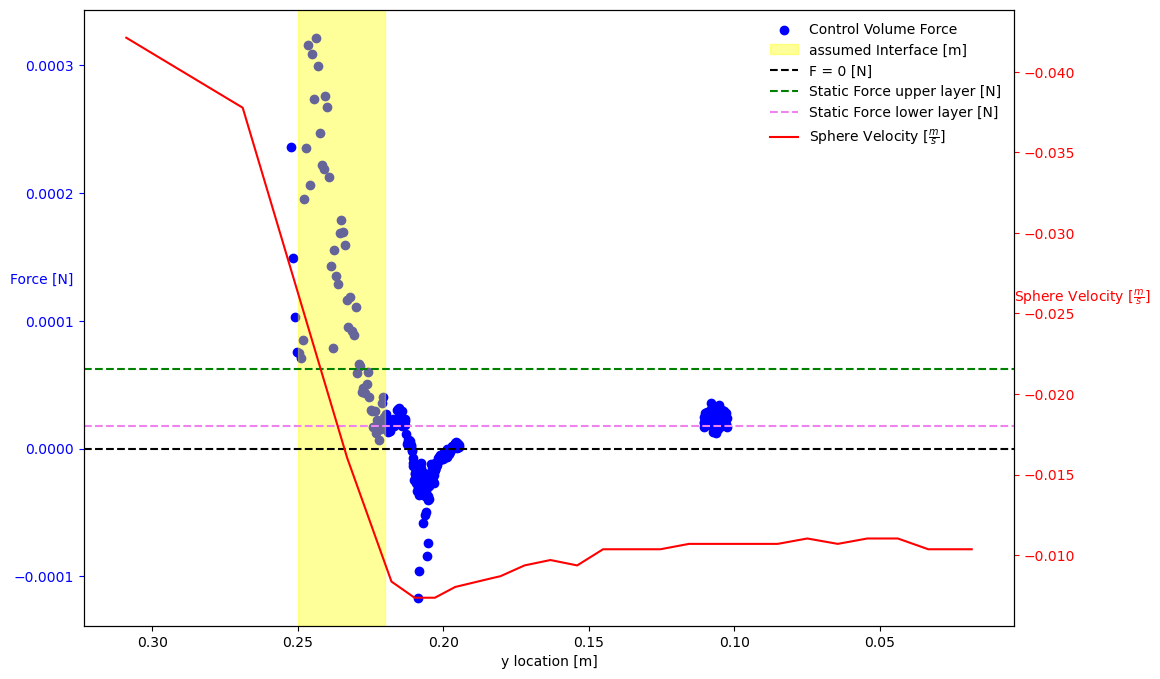

In [16]:
import matplotlib.pyplot as plt

import matplotlib.patches as patches

# Create a figure and left axis
fig, ax1 = plt.subplots(figsize=(12, 8))
# plt.title('Combined Graph')

# Plot the data for the left axis (Force vs Location)
ax1.scatter(F_y_and_loc_np[:, 0], F_y_and_loc_np[:, 1], label='Control Volume Force', color='blue')

# Define the coordinates and dimensions of the rectangle
rect_x = inteface_lower #[m]
rect_width = interface_width
rect_y = ax1.get_ylim()[0]
rect_height = ax1.get_ylim()[1] - rect_y # Cover the entire y-axis range

# # Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='assumed Interface [m]')
ax1.add_patch(rect_patch)

ax1.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax1.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='Static Force upper layer [N]')
ax1.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='Static Force lower layer [N]')

ax1.set_xlabel('y location [m]')
ax1.set_ylabel('Force [N]', color='blue', rotation=0, labelpad=-20, y=0.55)
ax1.tick_params('y', colors='blue')
# ax1.legend(loc='upper left', fancybox=True, framealpha=0)

# Create a twin axis for the right axis (Sphere Velocity)
ax2 = ax1.twinx()
ax2.plot(y_axis, y_velocity, color='red', label=r'Sphere Velocity $ \left[ \frac {m} {s} \right]$')
ax2.set_ylabel(r'Sphere Velocity $ \left[ \frac {m} {s} \right]$', color='red', rotation=0, labelpad=5, y=0.55)

ax2.tick_params('y', colors='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fancybox=True, framealpha=0)

# Invert x-axis
ax1.invert_xaxis()
ax2.invert_yaxis()


# save?
plt.savefig(os.path.join(save_folder, 'Combined Graph.svg'), transparent=True, bbox_inches='tight')
# plt.savefig(os.path.join(save_folder, 'Combined Graph.png'), transparent=True, bbox_inches='tight', dpi = 1000)
# plt.savefig(os.path.join(save_folder, 'Combined Graph.eps'), transparent=True, bbox_inches='tight')


# Show the plot
plt.show()

Lets make a Cd graph
$ C_d = \frac{F}{\frac{1}{2}\rho U^2 \cdot S_p} $

where $S_p = \frac{\pi \cdot ({sphere\ diameter})^2} {4}$ is the projected surface area

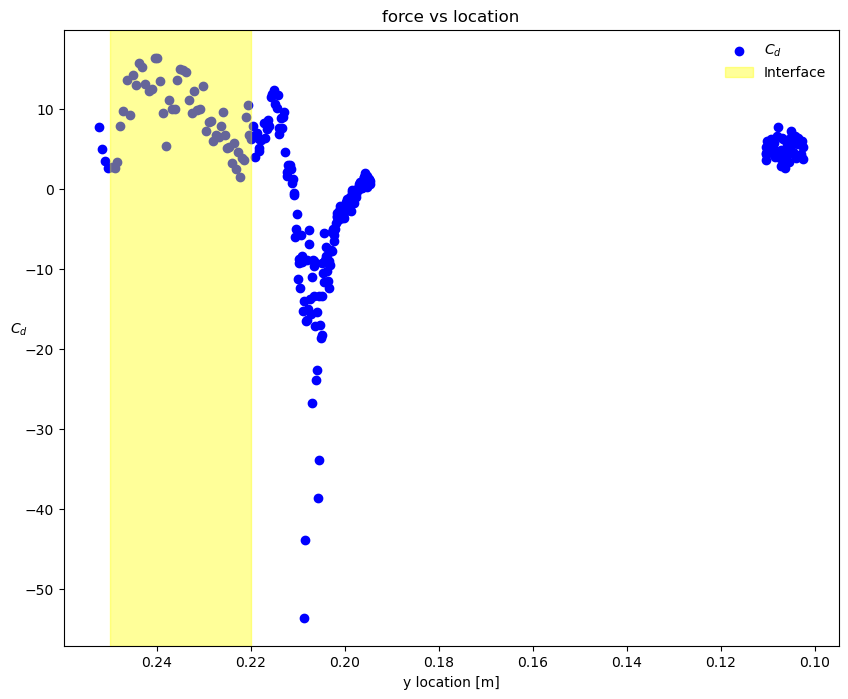

In [17]:
C_d_and_loc = np.copy(F_y_and_loc_np)
C_d_and_loc[:,1] = C_d_and_loc[:,1]/(0.5*(np.pi/4*sphere_diameter**2)*rho_function(C_d_and_loc[:,0])*y_velocity_meter_func(C_d_and_loc[:,0])**2)


fig, ax = plt.subplots(figsize=(10, 8))
plt.title('force vs location')
ax.scatter(C_d_and_loc[:,0], C_d_and_loc[:,1], label=r'$C_d$', color = 'blue')

# Define the coordinates and dimensions of the rectangle
rect_x = inteface_lower #[m]
rect_width = interface_width
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range

# Create a Rectangle patch with transparency (alpha)
import matplotlib.patches as patches
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)

ax.set_xlabel('y location [m]')
ax.set_ylabel(r'$C_d$', rotation=0)
ax.legend(fancybox=True, framealpha=0)
plt.gca().invert_xaxis()
plt.show()

הנקודה האדומה מציינת את מרכז הכדור, נראה שהיא לא בדיוק באמצע ויש כמה סיבות עיקריות

1) מיקום הנקודה האדומה זה אינטרפולציה לינארית בין 2 תמונות
2) האלגוריתם לא מוצא את המרכז בצורה מושלמת, בעיקר בשכבת המעבר כאשר יש שוני באינדקסי שבירה, הכדור מתעוות והאלגוריתם מוצא את מה שהכי קרוב
3) סביר מאוד שהמרכז לא נופל בפיקסל שלם, למשל הוא נמצא בפיקסלים (10.21, 10.68) ואי אפשר לייצג את זה כי חייב לבחור נקודה שתיהיה בפיקסל ספציפי ( במספר שלם) אז המחשב יציג לנו אותו ב (10,10)

optional show streamline

In [18]:
if False:
    pictures_list = Mf.find_pictures(multy_cut_image_folder)
    new_multy_cut_image_folder = os.path.join(multy_cut_image_folder, 'edited')
    Mf.create_directory(new_multy_cut_image_folder)
    for ind, el in enumerate(sphere_location_relativ_to_piv):
        img = Mf.read_image(pictures_list[ind])
        Mf.save_stream_line_on_pic(txt_files_path[ind], save_path=os.path.join(new_multy_cut_image_folder, os.path.basename(pictures_list[ind])), scale=0.01, width = 0.003,scaling_factor=scaling_factor, on_img=True, image_name=pictures_list[ind])
        plt.close()
    Mf.display_images_with_points_napari(new_multy_cut_image_folder)